# Ionosonde

## Japan

https://wdc.nict.go.jp/Ionosphere/en/archive/isdj_auto_txt.html

- Wakkanai - WK546(Wakkanai/Sarobetsu)
- Kokubunji - TO536(Kokubunji)
- Okinawa - OK426(Okinawa/Oogimi)

- 20240322 - 20240325

- foF2, hpF2

---
Time in the data is Japanese Standard Time(JST). JST=UT+9hours

foF2 [MHz] = foF2 / 100

In [ ]:
# from urllib.request import urlretrieve

# urlretrieve("https://wdc.nict.go.jp/Ionosphere/en/archive/observation-history/factor-auto-WK546-2024.sjis.txt",
#             "data/Ionosonde/japan/WK546-2024.txt")

# urlretrieve("https://wdc.nict.go.jp/Ionosphere/en/archive/observation-history/factor-auto-TO536-2024.sjis.txt",
#             "data/Ionosonde/japan/TO536-2024.txt")

# urlretrieve("https://wdc.nict.go.jp/Ionosphere/en/archive/observation-history/factor-auto-OK426-2024.sjis.txt",
#             "data/Ionosonde/japan/OK426-2024.txt");

In [ ]:
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [ ]:
file = "data/Ionosonde/japan/WK546_20240322(082).TXT"
full_txt = open(file, 'r')
row = 0 
while True:
    row += 1
    line = full_txt.readline()
    if not line:
        break

    if "#" in line and row == 1:
        header = line.split(sep=',')
    else:
        columns = line.split(sep=',')
        break
full_txt.close()
print(header)
print(columns)

['#                       fmin  ', '   foE   ', "   h'E   ", '   foEs  ', "   h'Es  ", '   fbEs  ', '   foF1  ', "   h'F   ", "   h'F2  ", '   foF2  ', '   fxF2  ', '   M3F2  ', '   fxI   ', '   hpF2  ', '   fxEs  ', '   ftEs  ', '   fxF1  ', '   FSPR  ', '   MUF   ', '   Es1   ', '   Es2   ', '   Es    ', '   W     \n']
['WK546', '20240322000000:  136    ', '     ----', '     ----', '     ----', '     ----', '     ----', '     ----', '     ----', ' 3140----', '  614    ', '  666----', '     ----', '  596X   ', ' 3848----', '     ----', '     ----', '     ----', '   96----', ' 1568----', '-----G   ', '-----    ', '     ----', '-----    \n']


In [ ]:
columns[1]

'20240322000000:  136    '

In [ ]:
columns[1][:14]

'20240322000000'

In [ ]:
datetime.datetime.strptime(columns[1][:14], "%Y%m%d%H%M%S")

datetime.datetime(2024, 3, 22, 0, 0)

In [ ]:
columns[10].strip()

'614'

In [ ]:
float(columns[10].strip()) / 100

6.14

In [ ]:
import re
re.findall(r'\d+', "1854N")[0]

'1854'

In [ ]:
def get_df(file):
    data = {
        'time': [],
        'foF2': [],
    }

    full_txt = open(file, 'r')
    row = 0 
    while True:
        row += 1
        line = full_txt.readline()
        if not line:
            break

        if "#" in line:
            continue
        else:
            columns = line.split(sep=',')
            data['time'].append(datetime.datetime.strptime(columns[1][:14], "%Y%m%d%H%M%S"))
            val = columns[10].strip()
            if val == '':
                data['foF2'].append(None)
            else:
                try:
                    data['foF2'].append(float(val) / 100)
                except:
                    val = re.findall(r'\d+', val)[0]
                    data['foF2'].append(float(val) / 100)
    full_txt.close()

    df = pd.DataFrame(data)
    return df

In [ ]:
df_wk546 = get_df("data/Ionosonde/japan/WK546_20240322(082).TXT")
df_wk546

,time,foF2
0,2024-03-22 00:00:00,6.14
1,2024-03-22 00:15:00,5.90
2,2024-03-22 00:30:00,5.82
3,2024-03-22 00:45:00,5.78
4,2024-03-22 01:00:00,5.86
...,...,...
379,2024-03-25 22:45:00,6.62
380,2024-03-25 23:00:00,6.30
381,2024-03-25 23:15:00,6.22
382,2024-03-25 23:30:00,6.18


In [ ]:
def get_quite_storm(df):
    df_quite_22 = df[(df['time'] >= '2024-03-22') & (df['time'] < '2024-03-23')]
    df_quite_22 = df_quite_22.sort_values(by='time')
    df_quite_22 = df_quite_22.reset_index(drop=True)
    df_quite_copy = df_quite_22.copy()
    df_quite_copy['time'] += pd.DateOffset(days=1)
    df_quite = pd.concat([df_quite_22, df_quite_copy]).reset_index(drop=True)
    df_quite['offset'] = df_quite['time'] - df_quite['time'].min()

    df_storm = df[(df['time'] >= '2024-03-24') & (df['time'] < '2024-03-26')]
    df_storm = df_storm.sort_values(by='time')
    df_storm = df_storm.reset_index(drop=True)
    df_storm['offset'] = df_storm['time'] - df_storm['time'].min()

    return df_quite, df_storm


def plot_quite_storm(df_quite, df_storm, loc='Wakkanai', ymin=2, ymax=16, yma=2, ymi=0.5):
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)
    ax.plot(df_quite['offset'].dt.total_seconds(), df_quite['foF2'], 'k-', label='quite')
    ax.plot(df_storm['offset'].dt.total_seconds(), df_storm['foF2'], 'r-', label='storm')

    ax.xaxis.set_major_locator(ticker.MultipleLocator(base=12*3600))
    formatter = ticker.FuncFormatter(lambda x, _: str(datetime.timedelta(seconds=x))[:-3])                                                                                                                                                                                                                         
    ax.xaxis.set_major_formatter(formatter)
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(base=2.4*3600))

    ax.yaxis.set_major_locator(ticker.MultipleLocator(base=yma))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(base=ymi))

    ax.set_ylim(ymin, ymax)

    ax.tick_params(axis='both', which='minor', length=5, direction='in', labelsize=15)
    ax.tick_params(axis='both', which='major', length=12, direction='in', labelsize=15)
    ax.set_ylabel('foF2 (MHz)', fontsize=15)
    ax.set_title(f'{loc} Ionosonde foF2 plot (final)', fontsize=20)
    ax.legend(prop={'size': 15})

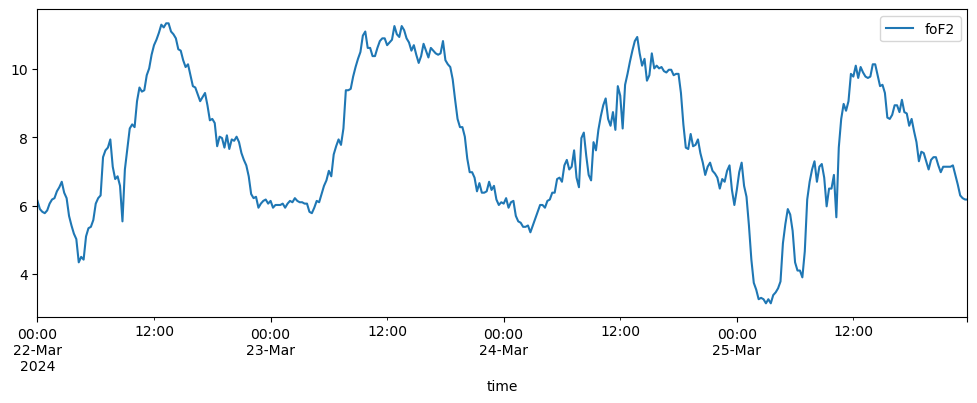

In [ ]:
df_wk546.plot(x='time', y='foF2', figsize=(12, 4));

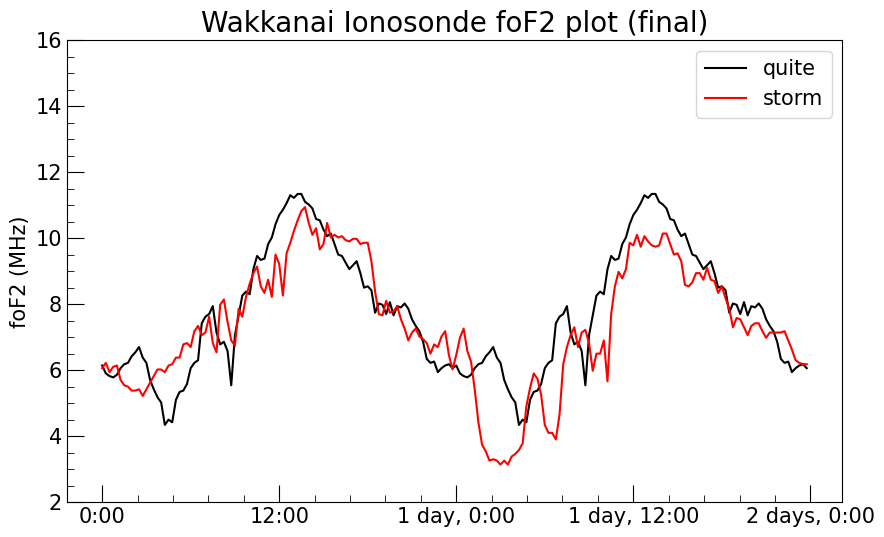

In [ ]:
plot_quite_storm(*get_quite_storm(df_wk546));

`ionosonde_analysis_jp.pro`

<img src="fig/wk_full.png" width="600"/>
<img src="fig/wk_final.png" width="600"/>

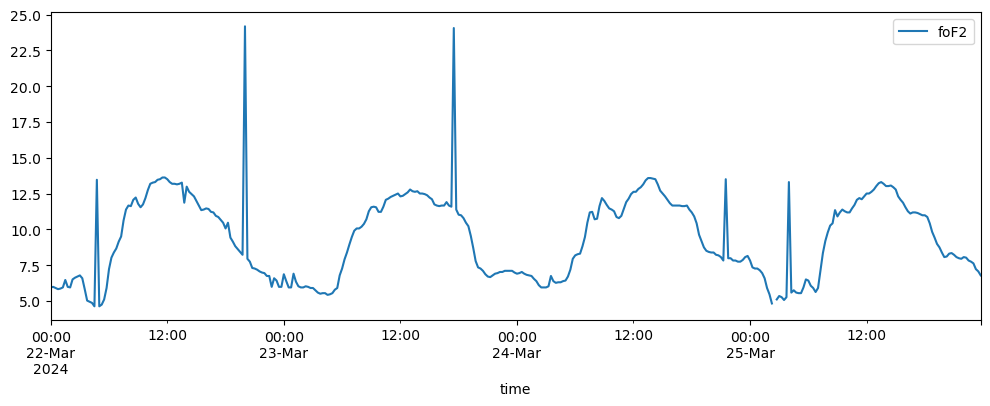

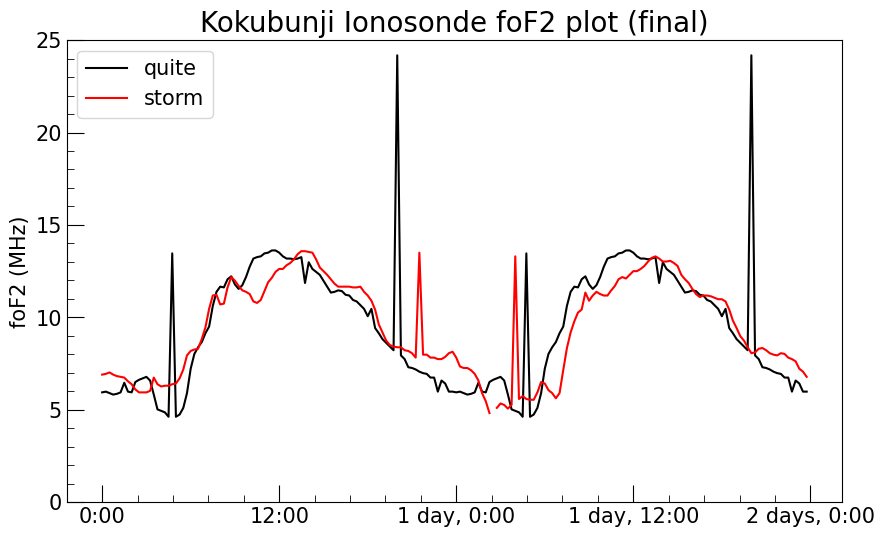

In [ ]:
df_to536 = get_df("data/Ionosonde/japan/TO536_20240322(082).TXT")
df_to536.plot(x='time', y='foF2', figsize=(12, 4));
plot_quite_storm(*get_quite_storm(df_to536), loc='Kokubunji', ymin=0, ymax=25, yma=5, ymi=1);

`ionosonde_analysis_jp.pro`

<img src="fig/kk_full.png" width="600"/>
<img src="fig/kk_final.png" width="600"/>

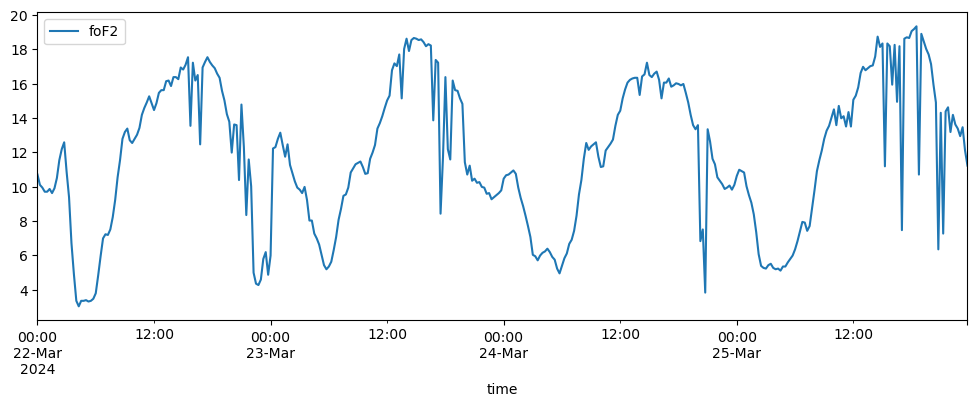

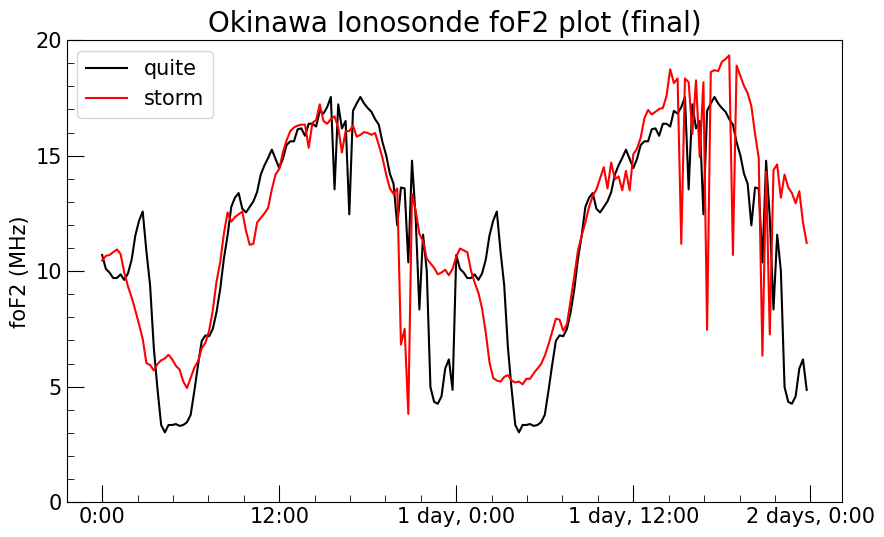

In [ ]:
df_ok426 = get_df("data/Ionosonde/japan/OK426_20240322(082).TXT")
df_ok426.plot(x='time', y='foF2', figsize=(12, 4));
plot_quite_storm(*get_quite_storm(df_ok426), loc='Okinawa', ymin=0, ymax=20, yma=5, ymi=1);

`ionosonde_analysis_jp.pro`

<img src="fig/ok_full.png" width="600"/>
<img src="fig/ok_final.png" width="600"/>